In [64]:
import wikipedia
import codecs
import collections
import sys
import string
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Скачивание статей из Википедии

In [65]:
def get_texts_for_lang(lang, n=10): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        except wikipedia.exceptions.WikipediaException:
            print('Skipping page {}'.format(page_name))
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

## Языки

In [66]:
code2lang = wikipedia.languages()

#### Будем работать со следующими языками

In [67]:
langs = ['be', 'bg', 'ru', 'uk', 'fr', 'en', 'de', 'es']

In [68]:
k = 0
for every_lang in langs:
    print([code2lang[lang] for lang  in langs][k], '(', every_lang, ')')
    k += 1

беларуская ( be )
български ( bg )
русский ( ru )
українська ( uk )
français ( fr )
English ( en )
Deutsch ( de )
español ( es )


#### Создание корпусов

In [69]:
wiki_texts = {}
for lang in langs:
    wiki_texts[lang] = get_texts_for_lang(lang, 100)
    print(lang, len(wiki_texts[lang]))

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Skipping page Барышаўка
Skipping page Астрэй
Skipping page Азгур
Skipping page Фландрыя
Skipping page Вялікая вайна
Skipping page Камода
Skipping page Новыя Лукі
be 93
Skipping page Челопек (пояснение)
Skipping page Кордоба (пояснение)
Skipping page Поп (пояснение)
bg 97
Skipping page Стефанос
Skipping page Киевец
Skipping page Карлссон, Никлас
Skipping page Коррез (значения)
Skipping page Берёзка
Skipping page Джоус, Джеймс
ru 94
Skipping page Ота
Skipping page 1837 (значення)
uk 98
Skipping page Saison 1974-1975 de la LNH
Skipping page Beccaria
Skipping page Baland
Skipping page Le Sport
Skipping page Double Vision (album de Foreigner)
Skipping page Duboys
Skipping page Inch'Allah (homonymie)
fr 93
Skipping page Jalikan
Skipping page The Double Man
Skipping page Australian tigers
Skipping page Victor Rydberg
Skipping page First United Presbyterian Church
Skipping page Zomba
Skipping page Baena (disambiguation)
en 93
Skipping page Oskar Graf (Politiker)
Skipping page Critical Care
Ski

## Первый метод: частотные слова

#### Чистим текст от тегов

In [70]:
def remove_tags(text):
    no_tags_text = re.sub(r'<[^>]+>', ' ', text)
    no_space_sequences_text = re.sub('  +', ' ', no_tags_text)
    return no_space_sequences_text

#### Токенизация

In [71]:
# удаляем знаки препинания
def tokenize(text):
    punct_extended = string.punctuation + '«»—…“”'
    table = str.maketrans({ch: None for ch in punct_extended})
    return [word.translate(table) for word in text.split()]

#### Список частотных слов

In [72]:
def frequent_list(langs, wiki_texts):
    lang_freqs = {}
    for lang in wiki_texts:
        corpus = wiki_texts[lang]
        lang_freqs[lang] = collections.defaultdict(lambda: 0)
        for article in corpus:
            for word in tokenize(remove_tags(article.replace('\n', '').lower())):
                lang_freqs[lang][word] += 1
    return lang_freqs

#### Фильтрация повторяющихся токенов

In [73]:
def filter_tokens(d):
    result = {}
    toks = []
    for key, value in d.items():
        result[key] = {}
        toks = toks + list(value.keys())
    duplicates  = [item for item, count in collections.Counter(toks).items() if count > 1]
    for key2, value2 in d.items():
        for key3, value3 in value2.items():
            if key3 not in duplicates:
                result[key2].update({key3 : value3})
    return(result)

#### Список  самых частотных слов

In [74]:
def most_frequent(d, keys, num):
    most_freqs = {}
    for k in keys:
        most_freqs[k] = set(sorted(d[k], key=lambda w: d[k][w], reverse=True)[:num])
    return most_freqs

In [75]:
def main_freq(langs, wiki_texts):
    # составляем частотный список
    lang_freqs = frequent_list(langs, wiki_texts)
    # фильтруем токены
    lang_freqs_filtered = filter_tokens(lang_freqs)
    # достаём самые частотные
    most_freq = most_frequent(lang_freqs_filtered, langs, 300)
    return most_freq

#### Определение языка корпусным методом

In [76]:
def corpus_method(text, most_freq):
    result = {}
    for lang in most_freq:
        result[lang] = len([word for word in tokenize(remove_tags(text.replace('\n', '').lower())) if word in most_freq[lang]])
    return sorted(result, key=lambda w: result[w], reverse=True)[0]

# Второй метод: частотные символьные n-граммы

#### Преобразование строки в массив n-грамм заданной длины

In [77]:
from itertools import islice, tee

def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

#### Список частотных ngram

In [78]:
def frequent_ngram_list(langs, wiki_texts):
    lang_freqs = {}
    for lang in wiki_texts:
        corpus = wiki_texts[lang]
        lang_freqs[lang] = collections.defaultdict(lambda: 0)
        for article in corpus:
            for ngram in make_ngrams(remove_tags(article.replace('\n', '').lower())):
                lang_freqs[lang][ngram] += 1
    return lang_freqs

In [79]:
def main_freq_ngram(langs, wiki_texts):
    # составляем частотный список
    lang_freqs = frequent_ngram_list(langs, wiki_texts)
    # фильтруем ngramы
    lang_freqs_filtered = filter_tokens(lang_freqs)
    # достаём самые частотные ngramы
    most_freq = most_frequent(lang_freqs_filtered, langs, 300)
    return most_freq

#### Определение языка n-граммным методом

In [80]:
def ngram_method(text, most_freq):
    result = {}
    for lang in most_freq:
        result[lang] = len([ngram for ngram in make_ngrams(remove_tags(text.replace('\n', '').lower())) if ngram in most_freq[lang]])
    return sorted(result, key=lambda w: result[w], reverse=True)[0]

#### Определяем язык двумя методами

In [83]:
def predict_lang(filename, most_freq, most_freq_n):
    text = open(filename,'r',encoding='utf-8').read()
    print('Корпусный метод: ', corpus_method(text, most_freq))
    print('n-граммный метод: ', ngram_method(text, most_freq_n))

In [84]:
most_freq = main_freq(langs, wiki_texts)
most_freq_n = main_freq_ngram(langs, wiki_texts)

In [85]:
for lang in langs:
    print('Язык текста: ', lang)
    predict_lang('/Users/irene/Downloads/HW2/' + lang + '.txt', most_freq, most_freq_n)

Язык текста:  be
Корпусный метод:  be
n-граммный метод:  be
Язык текста:  bg
Корпусный метод:  bg
n-граммный метод:  bg
Язык текста:  ru
Корпусный метод:  ru
n-граммный метод:  ru
Язык текста:  uk
Корпусный метод:  uk
n-граммный метод:  uk
Язык текста:  fr
Корпусный метод:  fr
n-граммный метод:  fr
Язык текста:  en
Корпусный метод:  en
n-граммный метод:  en
Язык текста:  de
Корпусный метод:  de
n-граммный метод:  de
Язык текста:  es
Корпусный метод:  es
n-граммный метод:  es


Везде определяется правильно.

# Отчет

In [86]:
wiki_texts_test = {}
for lang in langs:
    wiki_texts_test[lang] = get_texts_for_lang(lang, 100)
    print(lang, len(wiki_texts_test[lang]))

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


Skipping page Саковіч
Skipping page Рублева
Skipping page Скачок
Skipping page Пякарскі
be 96
Skipping page Сара (пояснение)
Skipping page Цветан Минков
Skipping page Бачев
Skipping page Бейшехир
bg 96
Skipping page СН
Skipping page Остапенко, Пётр
Skipping page Синий мост
Skipping page Хомейн (значения)
Skipping page Ток (Аляска)
Skipping page Зюзинское (сельское поселение)
Skipping page Нисимура
Skipping page Честерфилд
ru 92
Skipping page Хасін
Skipping page Сокур (значення)
Skipping page Бор (значення)
Skipping page Пинзеник (прізвище)
Skipping page Ойодо
uk 95
Skipping page Tropidonotus johannis
Skipping page Nana (film, 1934)
Skipping page Alvaro Mejia
Skipping page Wilhelmine-Louise de Hesse-Darmstadt
Skipping page Salvat
Skipping page Romain-aux-Bois
Skipping page Calama
Skipping page Dolores (Copán)
fr 92
Skipping page Middle of the road
Skipping page Mary Lake (Ontario)
Skipping page Tharrawaddy
Skipping page This Fire
Skipping page William Agnew
Skipping page Oconto
en 94
Sk

#### Проверяем каждый текст (статья в Википедии) на язык

In [87]:
def check_errors(wiki_texts_test, most_freq, most_freq_n):
    err_corp = 0# кол-во текстов с неправильным определением языка корпусным методом
    err_n = 0# кол-во текстов с неправильным определением языка n-граммным методом
    num_texts = 0# кол-во всех текстов
    for lang in wiki_texts_test:
        corpus = wiki_texts_test[lang]
        for article in corpus:
            num_texts += 1
            if lang != corpus_method(article, most_freq):
                err_corp += 1
            if lang != ngram_method(article, most_freq_n):
                err_n += 1
    return err_corp/num_texts, err_n/num_texts

In [88]:
err_pr_corp, err_pr_n = check_errors(wiki_texts_test, most_freq, most_freq_n)

In [89]:
print('Процент ошибки у корпусного метода:', err_pr_corp)
print('Процент ошибки у n-граммного метода:', err_pr_n)

Процент ошибки у корпусного метода: 0.006666666666666667
Процент ошибки у n-граммного метода: 0.05333333333333334


In [90]:
def predict_lang_corp(text, most_freq):
    return corpus_method(text, most_freq)
def predict_lang_n(text, most_freq_n):
    return ngram_method(text, most_freq_n)

In [91]:
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
true_labels_corp = []
predicted_labels_corp = []
true_labels_n = []
predicted_labels_n = []

for lang in wiki_texts_test:
    for text in wiki_texts_test[lang]:
        true_labels_corp.append(lang)
        predicted_labels_corp.append(predict_lang_corp(text, most_freq))
        true_labels_n.append(lang)
        predicted_labels_n.append(predict_lang_n(text, most_freq_n))

#### Классификация текстов с помощью корпусного метода

In [93]:
print(classification_report(true_labels_corp, predicted_labels_corp))

             precision    recall  f1-score   support

         be       0.97      1.00      0.98        96
         bg       1.00      0.99      0.99        96
         de       1.00      1.00      1.00        92
         en       0.99      0.98      0.98        94
         es       1.00      0.99      0.99        93
         fr       0.99      1.00      0.99        92
         ru       1.00      0.99      0.99        92
         uk       1.00      1.00      1.00        95

avg / total       0.99      0.99      0.99       750



In [94]:
labels_corp = list(set(true_labels_corp))

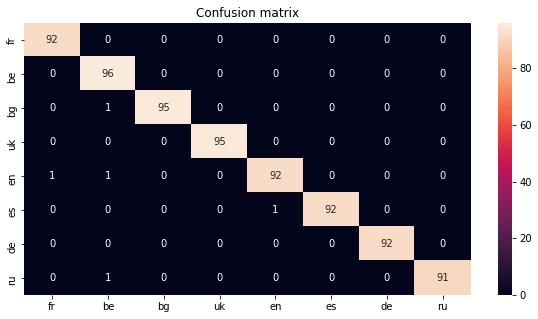

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels_corp, predicted_labels_corp, labels = labels_corp), 
            annot=True, 
            fmt="d", xticklabels=labels_corp, yticklabels=labels_corp, ax=ax)
plt.title("Confusion matrix")
plt.show()

#### Классификация текстов с помощью n-граммного метода

In [96]:
print(classification_report(true_labels_n, predicted_labels_n))

             precision    recall  f1-score   support

         be       0.79      1.00      0.88        96
         bg       0.99      1.00      0.99        96
         de       0.95      0.99      0.97        92
         en       1.00      0.65      0.79        94
         es       0.96      0.99      0.97        93
         fr       0.96      0.98      0.97        92
         ru       0.99      0.97      0.98        92
         uk       1.00      1.00      1.00        95

avg / total       0.95      0.95      0.94       750



In [97]:
labels_n = list(set(true_labels_n))

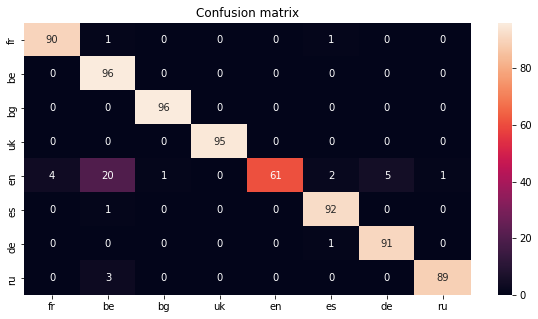

In [98]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data=confusion_matrix(true_labels_n, predicted_labels_n, labels = labels_n), 
            annot=True, 
            fmt="d", xticklabels=labels_n, yticklabels=labels_n, ax=ax)
plt.title("Confusion matrix")
plt.show()

## Корпусный метод работает лучше. У него процент ошибок меньше и, соответвенно, точность выше, чем у n-граммного. На confusion matrix видим, что путаются языки с одинаковым алфавитом (кириллическим / латиницей). Корпусный (словарный) метод лучше: мы отфильтровали повторяющиеся n-граммы, то есть в список попали менее частноные n-граммы (стоит учесть, что в языках больше совпадений n-грамм, чем слов). Возможно, это сказалось на точность второго метода.